### Re-visit the OpenSoundScape CNN model training process. 


- So far we've built a training dataset containing human tags of the target species, and inferrred a set of negative samples. 
- These samples still need some human verification to remove mis-labelled samples. 
- This notebook attempts to use OpenSoundScape's methods for training.

The resnet18 model didn't show convergence. 
The resnet 34 model showed convergence. 

The ordering of the labels in the source dataframe was making large differences to the reported metrics. If the absent label is at the 0th index and the present label is at index 1, the metrics look great, but swapping the order of the columns affects the scores. 

If I swapped the order of the labels so that present is at index 1 and absent at index 0, the model no longer converged at all, and would end up predicting 100% of the examples as belonging to the present class. 

During training, there are the same number of positive classes as absent classes. This is true of the validation set used during training too. The full unbalanced validation set contains far more absence than presence, and hence the number of false positives is much higher in the full validation set than in the balanced one. 


I can now check the effect of cleaning the dataset. 

In [1]:
description = "Try to replicate previous stable run"

In [2]:
# !pip install wandb
# ! pip install wandb --upgrade

In [3]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [4]:
# autoreload
%load_ext autoreload
%autoreload 2

In [5]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [6]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [7]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols, show_sample_from_df
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"


In [9]:
# df_train.sample()

# Log some hyperparameters

In [10]:
n_samples_per_class = 800
one_output_neuron = False
random_seed = 43
learning_rate = 0.01
epochs=10

In [11]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)

In [12]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# # optionally load these from disk instead

train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [13]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2 7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe


In [14]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    45081
 1.0     4211
 Name: count, dtype: int64,
 target_presence
 0.0    9947
 1.0    1043
 Name: count, dtype: int64)

In [15]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)
balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    800
 1.0    800
 Name: count, dtype: int64,
 1600)

In [16]:
balanced_train_df.head()

,,,target_absence,target_presence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-294795.mp3,25.5,28.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-316188.mp3,31.5,34.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-291910.mp3,19.5,22.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-552598.flac,40.5,43.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-817014.flac,40.5,43.5,1.0,0.0


In [17]:
def last_clip(df, idx):
    '''
    show last clip from a recording in dataframe with multi index.
    '''
    path = df.index[idx][0]
    return df.loc[path].iloc[-1].name[1]

def show_sample(df, idx):
    print(f"Present label: {df.iloc[idx].target_presence}")
    print(f"Last clip: {last_clip(df, idx)}")
    show_sample_from_df(df, idx)
    idx += 1
    return idx

In [18]:
idx=0

In [19]:
shuffled_balanced_train_df = balanced_train_df.sample(frac=1)
shuffled_balanced_valid_df = balanced_valid_df.sample(frac=1)

Present label: 0.0
Last clip: 510.0
../../data/raw/recordings/OSFL/recording-320982.mp3 378.0 381.0


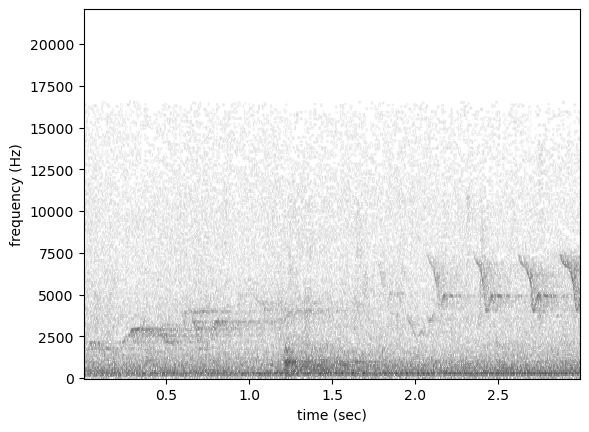

In [20]:
show_sample(shuffled_balanced_train_df, idx)
idx += 1

In [21]:
balanced_train_df.columns, balanced_valid_df.columns

(Index(['target_absence', 'target_presence'], dtype='object'),
 Index(['target_absence', 'target_presence'], dtype='object'))

In [22]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = True

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_absence', 'target_presence']

In [23]:
model.optimizer_params['lr'] = learning_rate


In [24]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

In [25]:
class_list

['target_absence', 'target_presence']

In [26]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


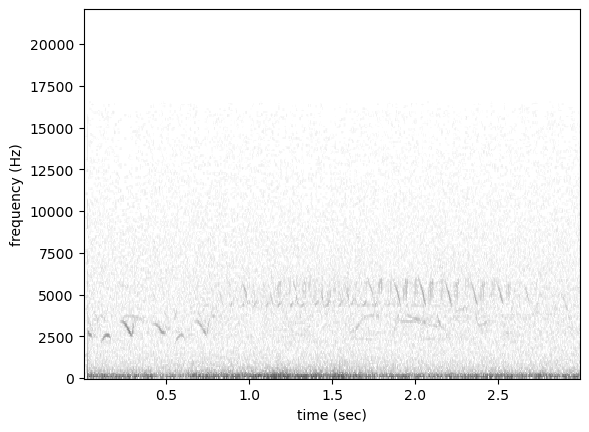

In [27]:
show_sample_from_df(present=True)


In [28]:
print(f'model.device is: {model.device}')

model.device is: mps


In [54]:
Path.cwd() / "1.15.1-mjg-osfl-revisit-opso-training-cycle.ipynb"

PosixPath('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.15.1-mjg-osfl-revisit-opso-training-cycle.ipynb')

In [63]:
%set_env WANDB_NOTEBOOK_NAME=({Path.cwd()}/1.15.1-mjg-osfl-revisit-opso-training-cycle.ipynb)

env: WANDB_NOTEBOOK_NAME=(/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.15.1-mjg-osfl-revisit-opso-training-cycle.ipynb)


# Weights and biases initialization

In [30]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "1.15.1-mjg-osfl-revisit-opso-training-cycle".
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [31]:
shuffled_balanced_valid_df.value_counts()

target_absence  target_presence
0.0             1.0                500
1.0             0.0                500
Name: count, dtype: int64

In [47]:
model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 17


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 17 [batch 0/25, 0.00%] 
	DistLoss: 0.221
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 18


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 18 [batch 0/25, 0.00%] 
	DistLoss: 0.250
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 19


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 19 [batch 0/25, 0.00%] 
	DistLoss: 0.338
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

wandb: Network error (ConnectionError), entering retry loop.


Metrics:

Training Epoch 20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 20 [batch 0/25, 0.00%] 
	DistLoss: 0.203
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 21


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 21 [batch 0/25, 0.00%] 
	DistLoss: 0.297
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 22


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 22 [batch 0/25, 0.00%] 
	DistLoss: 0.197
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 23


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 23 [batch 0/25, 0.00%] 
	DistLoss: 0.217
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 24


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 24 [batch 0/25, 0.00%] 
	DistLoss: 0.233
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 25


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 25 [batch 0/25, 0.00%] 
	DistLoss: 0.233
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 26


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 26 [batch 0/25, 0.00%] 
	DistLoss: 0.207
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 25 with Validation score 0.863.


In [48]:
model.classes

['target_absence', 'target_presence']

In [33]:
# model.train(
#     shuffled_balanced_train_df,
#     shuffled_balanced_valid_df,
#     epochs = 4,
#     batch_size = 64,
#     num_workers = 4, #4 parallelized cpu tasks for preprocessing
#     log_interval = 100,
#     save_interval = 10,
#     wandb_session = wandb_session,
#     )

In [34]:
model.valid_metrics

{0: {'confusion_matrix': array([[ 14, 486],
         [  2, 498]]),
  'precision': 0.5060975609756098,
  'recall': 0.996,
  'f1': 0.6711590296495957,
  'jaccard': 0.26647972006497334,
  'hamming_loss': 0.488},
 1: {'confusion_matrix': array([[169, 331],
         [ 40, 460]]),
  'precision': 0.5815423514538559,
  'recall': 0.92,
  'f1': 0.7126258714175059,
  'jaccard': 0.43325645139724556,
  'hamming_loss': 0.371},
 2: {'confusion_matrix': array([[416,  84],
         [121, 379]]),
  'precision': 0.8185745140388769,
  'recall': 0.758,
  'f1': 0.7871235721703012,
  'jaccard': 0.6594299406613284,
  'hamming_loss': 0.205},
 3: {'confusion_matrix': array([[363, 137],
         [ 75, 425]]),
  'precision': 0.7562277580071174,
  'recall': 0.85,
  'f1': 0.8003766478342749,
  'jaccard': 0.6492471503651628,
  'hamming_loss': 0.212},
 4: {'confusion_matrix': array([[444,  56],
         [125, 375]]),
  'precision': 0.8700696055684455,
  'recall': 0.75,
  'f1': 0.8055853920515573,
  'jaccard': 0.69243

In [35]:
model.train_metrics

{0: {'confusion_matrix': array([[413, 387],
         [369, 431]]),
  'precision': 0.5268948655256723,
  'recall': 0.53875,
  'f1': 0.5327564894932015,
  'jaccard': 0.35819683295582383,
  'hamming_loss': 0.4725},
 1: {'confusion_matrix': array([[525, 275],
         [332, 468]]),
  'precision': 0.629878869448183,
  'recall': 0.585,
  'f1': 0.6066104990278678,
  'jaccard': 0.4495648779686088,
  'hamming_loss': 0.379375},
 2: {'confusion_matrix': array([[650, 150],
         [269, 531]]),
  'precision': 0.7797356828193832,
  'recall': 0.66375,
  'f1': 0.7170830519918974,
  'jaccard': 0.5834961350992074,
  'hamming_loss': 0.261875},
 3: {'confusion_matrix': array([[685, 115],
         [236, 564]]),
  'precision': 0.8306332842415317,
  'recall': 0.705,
  'f1': 0.7626774847870184,
  'jaccard': 0.6387951769099309,
  'hamming_loss': 0.219375},
 4: {'confusion_matrix': array([[682, 118],
         [192, 608]]),
  'precision': 0.837465564738292,
  'recall': 0.76,
  'f1': 0.7968545216251639,
  'jacc

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [36]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"osfl_model_{dt}")

# Show metrics

In [37]:
model.valid_metrics

{0: {'confusion_matrix': array([[ 14, 486],
         [  2, 498]]),
  'precision': 0.5060975609756098,
  'recall': 0.996,
  'f1': 0.6711590296495957,
  'jaccard': 0.26647972006497334,
  'hamming_loss': 0.488},
 1: {'confusion_matrix': array([[169, 331],
         [ 40, 460]]),
  'precision': 0.5815423514538559,
  'recall': 0.92,
  'f1': 0.7126258714175059,
  'jaccard': 0.43325645139724556,
  'hamming_loss': 0.371},
 2: {'confusion_matrix': array([[416,  84],
         [121, 379]]),
  'precision': 0.8185745140388769,
  'recall': 0.758,
  'f1': 0.7871235721703012,
  'jaccard': 0.6594299406613284,
  'hamming_loss': 0.205},
 3: {'confusion_matrix': array([[363, 137],
         [ 75, 425]]),
  'precision': 0.7562277580071174,
  'recall': 0.85,
  'f1': 0.8003766478342749,
  'jaccard': 0.6492471503651628,
  'hamming_loss': 0.212},
 4: {'confusion_matrix': array([[444,  56],
         [125, 375]]),
  'precision': 0.8700696055684455,
  'recall': 0.75,
  'f1': 0.8055853920515573,
  'jaccard': 0.69243

Here we can see how the opso resample operation leaves the dataframe sorted into classes, so suffling is a necessary next step. 

In [38]:
pd.concat([balanced_train_df.tail(), balanced_train_df.head()])

,,,target_absence,target_presence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-555445.flac,3.0,6.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-295707.mp3,7.5,10.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-104318.mp3,123.0,126.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-292017.mp3,1.5,4.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-255454.mp3,1.5,4.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-294795.mp3,25.5,28.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-316188.mp3,31.5,34.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-291910.mp3,19.5,22.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-552598.flac,40.5,43.5,1.0,0.0


In [39]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

# Confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

  0%|          | 0/1000 [00:00<?, ?it/s]

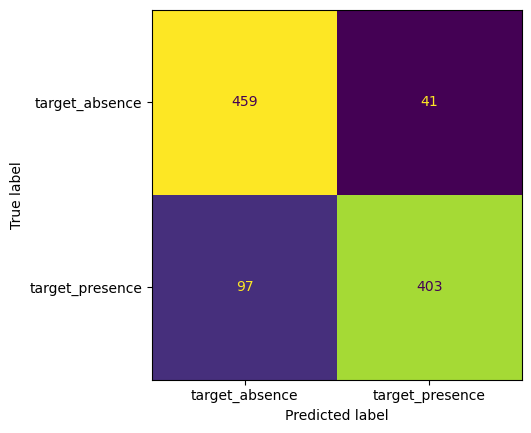

In [40]:
shuf_preds = model.predict(shuffled_balanced_valid_df)
opso.metrics.single_target_metrics(shuffled_balanced_valid_df, shuf_preds)
cm = opso.metrics.M.confusion_matrix(np.argmax(shuffled_balanced_valid_df, 1), (np.argmax(shuf_preds, 1)))

cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=model.classes)
cm_display.plot(colorbar=False)

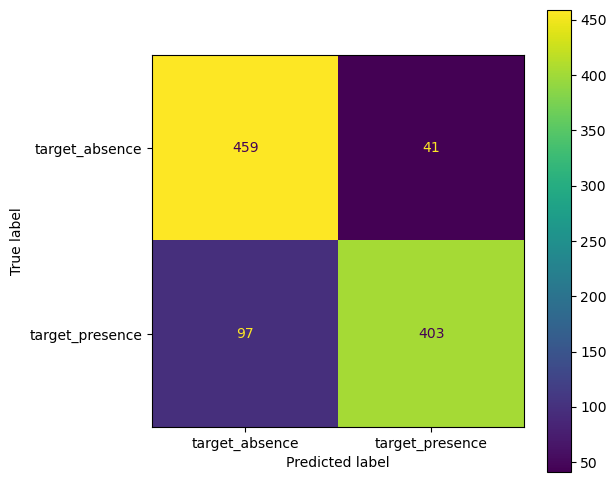

In [41]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cm_display.plot(ax=ax)
wandb.log({"Balanced classes confusion matrix": wandb.Image(fig)})

# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 
http://opensoundscape.org/en/latest/tutorials/predict_with_cnn.html

  0%|          | 0/10990 [00:00<?, ?it/s]

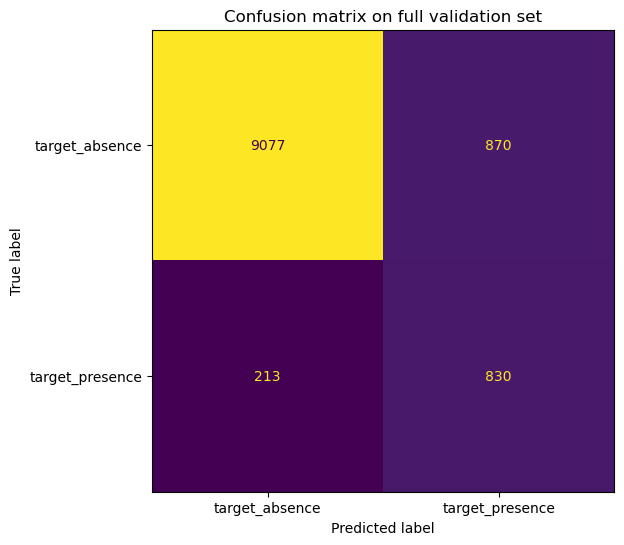

In [42]:
shuf_preds = model.predict(valid_df)
opso.metrics.single_target_metrics(valid_df, shuf_preds)
cm = opso.metrics.M.confusion_matrix(np.argmax(valid_df, 1), (np.argmax(shuf_preds, 1)))

cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=model.classes)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
# add a title
ax.set_title("Confusion matrix on full validation set")
cm_display.plot(ax=ax, colorbar=False)
wandb.log({"Confusion matrix on validation set with unbalanced classes": wandb.Image(fig)})


In [43]:
balanced_train_df.sample()

,,,target_absence,target_presence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-538636.flac,6.0,9.0,1.0,0.0


In [44]:
model.classes

['target_absence', 'target_presence']

In [45]:
# wandb.finish()

# Result: 

This proves that the model can learn with absence at index 0. It was the shuffling of the training dataset which was preventing the model from learning. 

# Train the model further

In [46]:
model.train(
    balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 10


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10 [batch 0/25, 0.00%] 
	DistLoss: 0.179
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 11


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11 [batch 0/25, 0.00%] 
	DistLoss: 0.363
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 12


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12 [batch 0/25, 0.00%] 
	DistLoss: 0.338
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 13


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13 [batch 0/25, 0.00%] 
	DistLoss: 0.218
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 14


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14 [batch 0/25, 0.00%] 
	DistLoss: 0.356
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 15


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15 [batch 0/25, 0.00%] 
	DistLoss: 0.366
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 16


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 16 [batch 0/25, 0.00%] 
	DistLoss: 0.293
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 17


  0%|          | 0/25 [00:00<?, ?it/s]

dyld[15215]: Assertion failed: (0), function deserialize, file ProcessAtlas.cpp, line 1981.



RuntimeError: DataLoader worker (pid(s) 15215) exited unexpectedly

In [ ]:
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"osfl_model_iter2_{dt}")

In [ ]:
# try training further on shuffled balanced train set
best_model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = 4,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 15


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15 [batch 0/25, 0.00%] 
	DistLoss: 0.338
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 16


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 16 [batch 0/25, 0.00%] 
	DistLoss: 0.166
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 17


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 17 [batch 0/25, 0.00%] 
	DistLoss: 0.345
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 18


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 18 [batch 0/25, 0.00%] 
	DistLoss: 0.235
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 18 with Validation score 0.859.


In [ ]:
# Try training further on the shuffled training set
best_model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = 6,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 19


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 19 [batch 0/25, 0.00%] 
	DistLoss: 0.198
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 20 [batch 0/25, 0.00%] 
	DistLoss: 0.305
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 21


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 21 [batch 0/25, 0.00%] 
	DistLoss: 0.137
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 22


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 22 [batch 0/25, 0.00%] 
	DistLoss: 0.105
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 23


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 23 [batch 0/25, 0.00%] 
	DistLoss: 0.171
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 24


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 24 [batch 0/25, 0.00%] 
	DistLoss: 0.098
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 19 with Validation score 0.857.


In [ ]:
best_model.valid_metrics

{0: {'confusion_matrix': array([[121, 379],
         [ 73, 427]]),
  'precision': 0.5297766749379652,
  'recall': 0.854,
  'f1': 0.6539050535987748,
  'jaccard': 0.3484742895603643,
  'hamming_loss': 0.452},
 1: {'confusion_matrix': array([[402,  98],
         [142, 358]]),
  'precision': 0.7850877192982456,
  'recall': 0.716,
  'f1': 0.7489539748953975,
  'jaccard': 0.6124152158284625,
  'hamming_loss': 0.24},
 2: {'confusion_matrix': array([[383, 117],
         [ 96, 404]]),
  'precision': 0.7754318618042226,
  'recall': 0.808,
  'f1': 0.7913809990205681,
  'jaccard': 0.6486993245080657,
  'hamming_loss': 0.213},
 3: {'confusion_matrix': array([[451,  49],
         [142, 358]]),
  'precision': 0.8796068796068796,
  'recall': 0.716,
  'f1': 0.7894156560088202,
  'jaccard': 0.6772934647532471,
  'hamming_loss': 0.191},
 4: {'confusion_matrix': array([[442,  58],
         [115, 385]]),
  'precision': 0.8690744920993227,
  'recall': 0.77,
  'f1': 0.816542948038176,
  'jaccard': 0.7043316

In [ ]:
# train for 10 more epochs with a lower learning rate
best_model.optimizer_params['lr']=0.001
best_model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = 10,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 25


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 25 [batch 0/25, 0.00%] 
	DistLoss: 0.227
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 26


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 26 [batch 0/25, 0.00%] 
	DistLoss: 0.203
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 27


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 27 [batch 0/25, 0.00%] 
	DistLoss: 0.221
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 28


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 28 [batch 0/25, 0.00%] 
	DistLoss: 0.199
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 29


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 29 [batch 0/25, 0.00%] 
	DistLoss: 0.157
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 30


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 30 [batch 0/25, 0.00%] 
	DistLoss: 0.101
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 31


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 31 [batch 0/25, 0.00%] 
	DistLoss: 0.153
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 32


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 32 [batch 0/25, 0.00%] 
	DistLoss: 0.143
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 33


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 33 [batch 0/25, 0.00%] 
	DistLoss: 0.141
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 34


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 34 [batch 0/25, 0.00%] 
	DistLoss: 0.133
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 32 with Validation score 0.872.


In [ ]:
predictions = best_model.predict(valid_df)
cm = opso.metrics.M.confusion_matrix(np.argmax(valid_df, 1), (np.argmax(predictions, 1)))

cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=best_model.classes)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
# add a title
ax.set_title("Confusion matrix on full validation set")
cm_display.plot(ax=ax, colorbar=False)


  0%|          | 0/10990 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute '_log'

In [ ]:
model.valid_metrics

{0: {'confusion_matrix': array([[121, 379],
         [ 73, 427]]),
  'precision': 0.5297766749379652,
  'recall': 0.854,
  'f1': 0.6539050535987748,
  'jaccard': 0.3484742895603643,
  'hamming_loss': 0.452},
 1: {'confusion_matrix': array([[402,  98],
         [142, 358]]),
  'precision': 0.7850877192982456,
  'recall': 0.716,
  'f1': 0.7489539748953975,
  'jaccard': 0.6124152158284625,
  'hamming_loss': 0.24},
 2: {'confusion_matrix': array([[383, 117],
         [ 96, 404]]),
  'precision': 0.7754318618042226,
  'recall': 0.808,
  'f1': 0.7913809990205681,
  'jaccard': 0.6486993245080657,
  'hamming_loss': 0.213},
 3: {'confusion_matrix': array([[451,  49],
         [142, 358]]),
  'precision': 0.8796068796068796,
  'recall': 0.716,
  'f1': 0.7894156560088202,
  'jaccard': 0.6772934647532471,
  'hamming_loss': 0.191},
 4: {'confusion_matrix': array([[442,  58],
         [115, 385]]),
  'precision': 0.8690744920993227,
  'recall': 0.77,
  'f1': 0.816542948038176,
  'jaccard': 0.7043316

In [ ]:
model = opso.cnn.load_model("best.model")
model.save(model_save_path / f"osfl_model_32_epoch{dt}")

# wandb.finish()


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█▁▁▂▃▃▁▂▃▃▄▅▁▂▃▃▄▅▆▆█
loss,█▇▅▅▄▄▄▄▃▄▃▃▃▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
epoch,9
loss,0.16362
